<a href="https://colab.research.google.com/github/vlehdrl-collab/Deagufinedust/blob/main/%EB%8C%80%EA%B5%AC%EC%8B%9C%EA%B3%B5%EA%B8%B0%EC%98%A4%EC%97%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# RandomForestRegressor와 MultiOutputRegressor 모델을 이용
# 대구시의 대기오염 상태를 바탕으로
# 오존(O3) 이산화질소(NO2) 일산화탄소(CO) 아황산가스(SO2)를 이용해
# 미세먼지(PM10)와 초미세먼지(PM2.5)를 회귀 예측하는 머신러닝

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install pyreadstat
!pip install pandas==2.2.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [5]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [6]:
df = pd.read_csv('/content/drive/MyDrive/fullstack_ai/data/DEAGU_AIR_20221231.csv', encoding='cp949')
df.describe()
df.isnull().sum() # 결측치 없음
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659348 entries, 0 to 659347
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   측정소명    659348 non-null  object 
 1   년       659348 non-null  int64  
 2   월       659348 non-null  int64  
 3   일       659348 non-null  int64  
 4   시       659348 non-null  int64  
 5   아황산가스   651754 non-null  float64
 6   미세먼지    644816 non-null  float64
 7   초미세먼지   649264 non-null  float64
 8   오존      653140 non-null  float64
 9   이산화질소   652911 non-null  float64
 10  일산화탄소   651629 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 55.3+ MB


In [7]:
# 년, 원, 일 합침
df['년월일'] = df['년'].astype(str) + '-' + df['월'].astype(str).str.zfill(2) + '-' + df['일'].astype(str).str.zfill(2)
df.head()

,측정소명,년,월,일,시,아황산가스,미세먼지,초미세먼지,오존,이산화질소,일산화탄소,년월일
0,수창동,2018,1,1,1,0.004,49.0,15.0,0.016,0.017,0.5,2018-01-01
1,수창동,2018,1,1,2,0.005,49.0,17.0,0.014,0.019,0.5,2018-01-01
2,수창동,2018,1,1,3,0.004,49.0,18.0,0.016,0.015,0.5,2018-01-01
3,수창동,2018,1,1,4,0.004,47.0,17.0,0.016,0.014,0.5,2018-01-01
4,수창동,2018,1,1,5,0.004,40.0,16.0,0.015,0.015,0.5,2018-01-01


In [8]:
# 날짜 별로 평균
df_daymean = df.groupby(['년월일'], as_index=False).agg({'아황산가스':'mean', '일산화탄소':'mean', '오존':'mean', '이산화질소':'mean', '미세먼지':'mean', '초미세먼지':'mean'})
df_daymean

,년월일,아황산가스,일산화탄소,오존,이산화질소,미세먼지,초미세먼지
0,2018-01-01,0.003920,0.503788,0.020867,0.019011,41.954545,19.784091
1,2018-01-02,0.004828,0.721374,0.015004,0.029195,67.719697,39.349810
2,2018-01-03,0.004049,0.436502,0.018122,0.021471,24.992337,14.919231
3,2018-01-04,0.003969,0.468093,0.014716,0.025883,32.441065,21.562738
4,2018-01-05,0.004176,0.495455,0.014045,0.029739,39.961390,28.160920
...,...,...,...,...,...,...,...
1821,2022-12-27,0.002412,0.480941,0.015407,0.029146,30.985882,19.895735
1822,2022-12-28,0.002555,0.507459,0.018245,0.026110,47.497664,31.698598
1823,2022-12-29,0.002531,0.389100,0.023945,0.018855,29.682464,18.547393
1824,2022-12-30,0.002641,0.484706,0.013473,0.027993,38.974118,27.150588


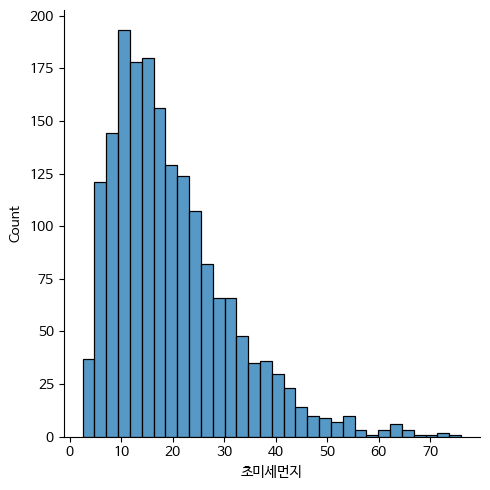

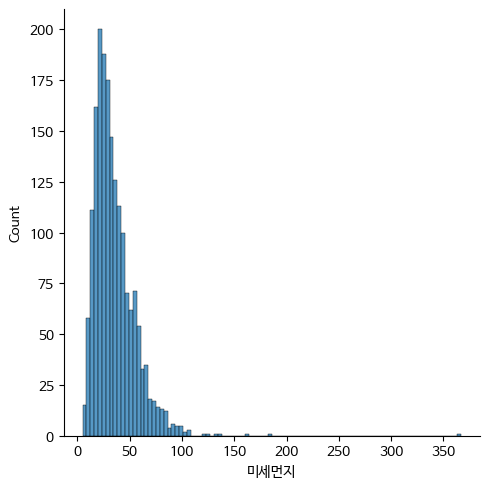

In [9]:
sns.displot(x='초미세먼지', kind='hist', data=df_daymean)
sns.displot(x='미세먼지', kind='hist', data=df_daymean)
plt.show()

<Axes: >

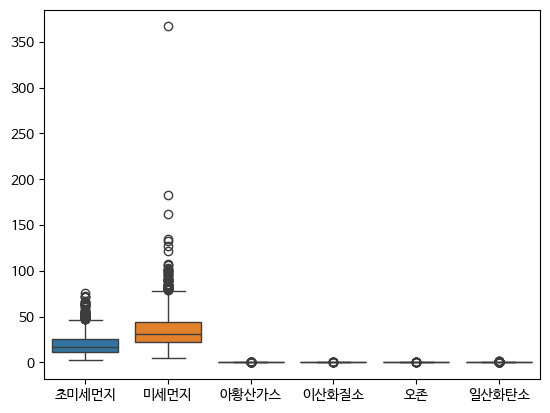

In [10]:
# 이상치 확인
sns.boxplot(data=df_daymean[['초미세먼지', '미세먼지', '아황산가스', '이산화질소', '오존', '일산화탄소']])

<Axes: >

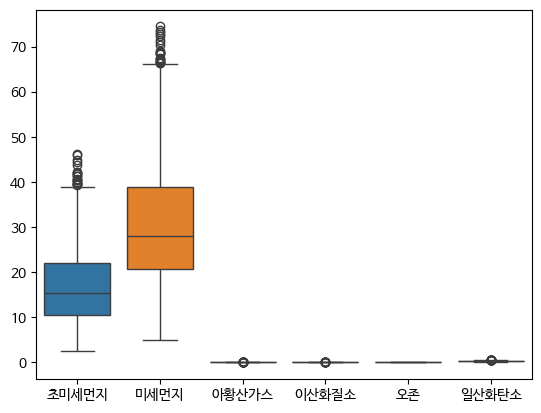

In [11]:
# 이상치 제거 함수
def remove_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25) # 하위 25%
    q3 = df[col_name].quantile(0.75) # 상위 25%
    iqr = q3 - q1 # IQR 계산
    lower_bound = q1 - (1.5 * iqr) # 하한 값 계산
    upper_bound = q3 + (1.5 * iqr) # 상한 값 계산
    df = df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)] # 이상치 제거
    return df

# PM10, PM2.5에 대한 이상치 제거
df_daymean = remove_outliers(df_daymean, '초미세먼지')
df_daymean = remove_outliers(df_daymean, '미세먼지')
df_daymean = remove_outliers(df_daymean, '아황산가스')
df_daymean = remove_outliers(df_daymean, '이산화질소')
df_daymean = remove_outliers(df_daymean, '오존')
df_daymean = remove_outliers(df_daymean, '일산화탄소')

# boxplot으로 이상치 제거 결과 확인
sns.boxplot(data=df_daymean[['초미세먼지', '미세먼지', '아황산가스', '이산화질소', '오존', '일산화탄소']])

In [12]:
# 상관계수
df_air = df_daymean.corr(numeric_only=True)
df_air

,아황산가스,일산화탄소,오존,이산화질소,미세먼지,초미세먼지
아황산가스,1.000000,0.621926,-0.092409,0.555505,0.570717,0.572446
일산화탄소,0.621926,1.000000,-0.293780,0.767830,0.615236,0.712623
오존,-0.092409,-0.293780,1.000000,-0.479803,0.151472,0.069457
이산화질소,0.555505,0.767830,-0.479803,1.000000,0.582523,0.631228
미세먼지,0.570717,0.615236,0.151472,0.582523,1.000000,0.880995
초미세먼지,0.572446,0.712623,0.069457,0.631228,0.880995,1.000000


[]

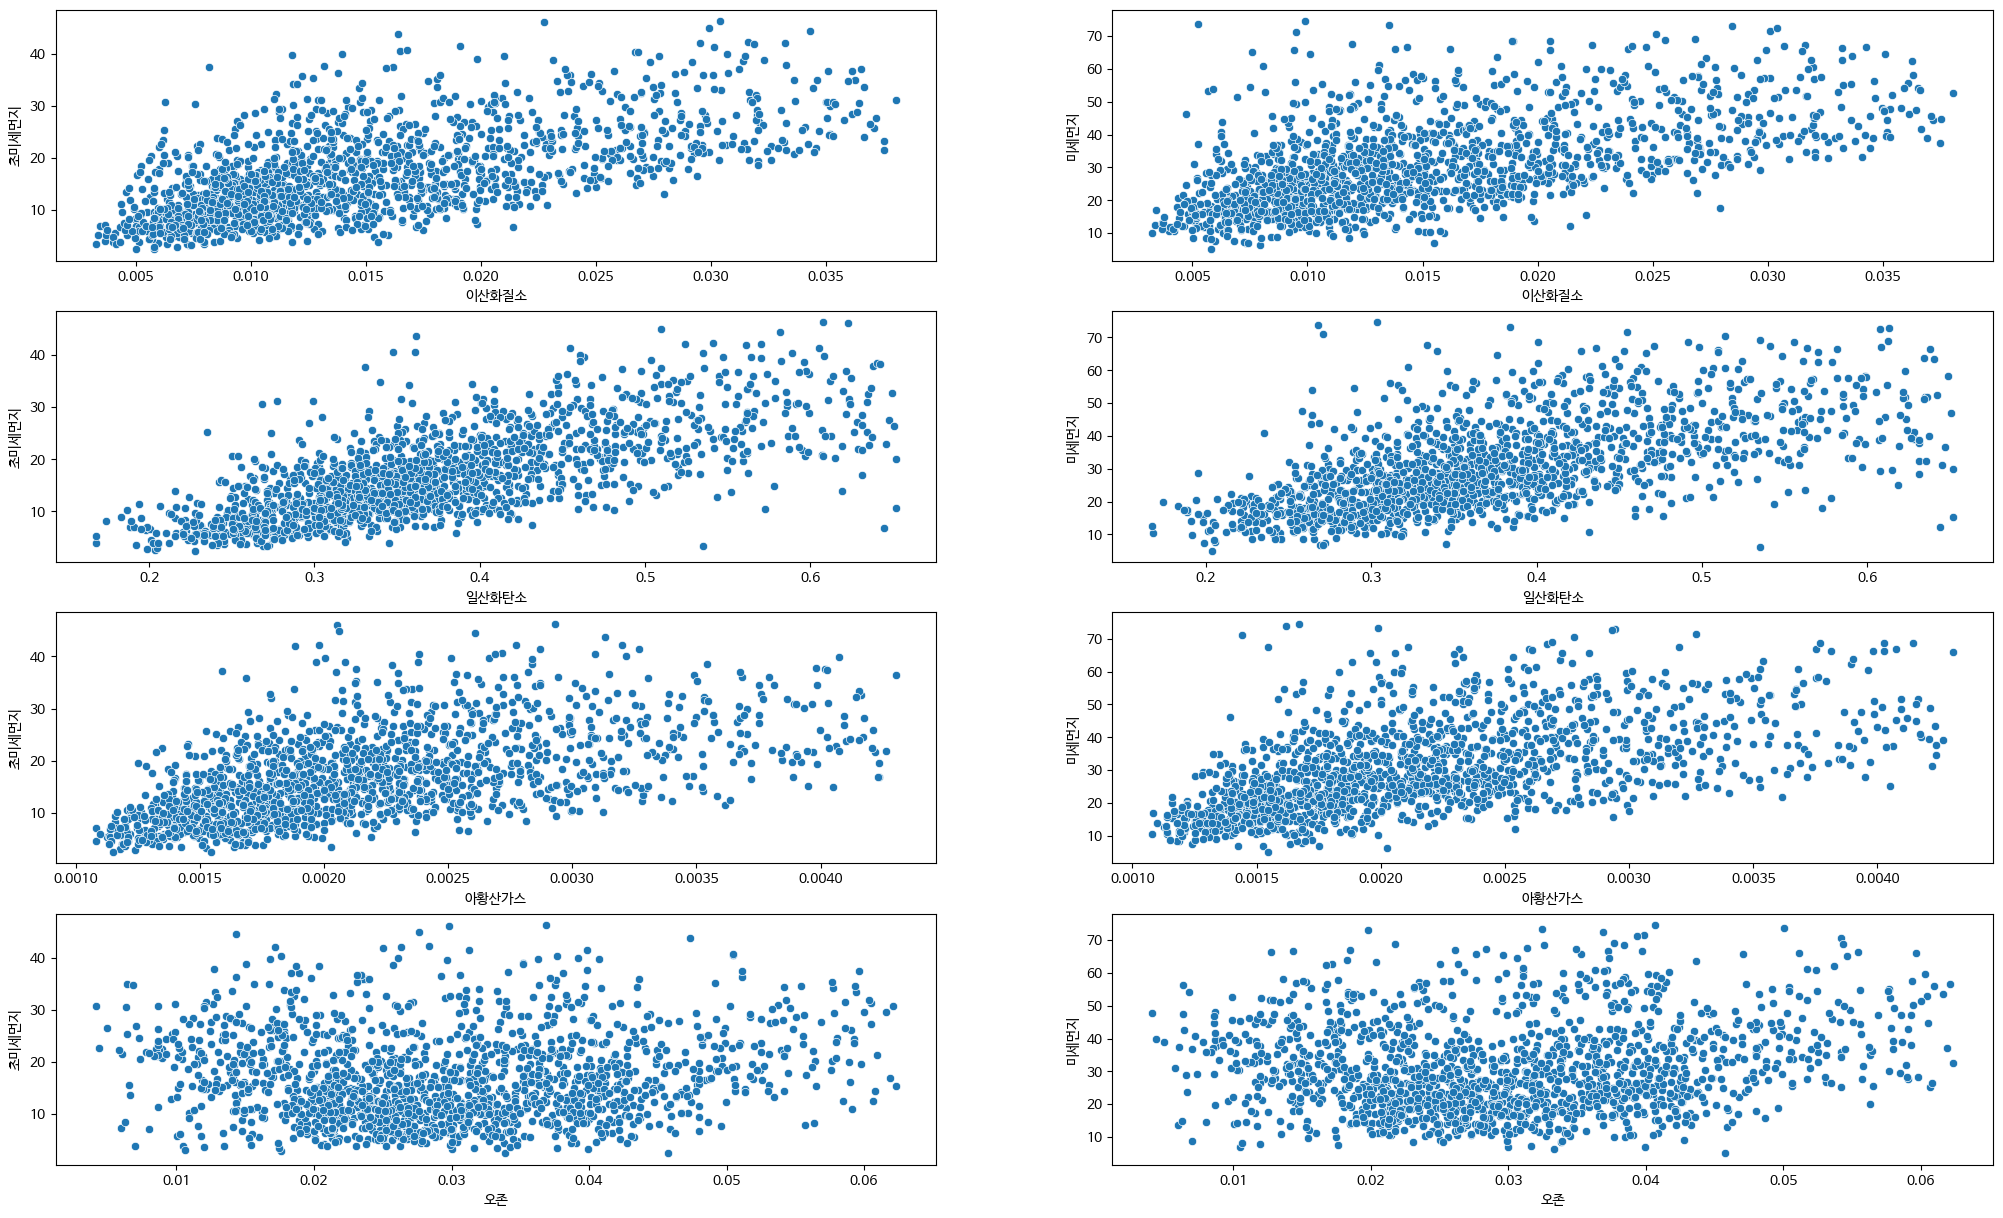

In [13]:
# 일간 평균으로 NO2(이산화질소), CO(일산화탄소), SO2(아황산가스), O3(오존)과 PM10, PM2.5의 상관관계 시각화
f, ax = plt.subplots(4, 2, figsize=(25,15))
sns.scatterplot(x='이산화질소', y= '초미세먼지', data=df_daymean, ax=ax[0,0])
sns.scatterplot(x='이산화질소', y= '미세먼지', data=df_daymean, ax=ax[0,1])
sns.scatterplot(x='일산화탄소', y= '초미세먼지', data=df_daymean, ax=ax[1,0])
sns.scatterplot(x='일산화탄소', y= '미세먼지', data=df_daymean, ax=ax[1,1])
sns.scatterplot(x='아황산가스', y= '초미세먼지', data=df_daymean, ax=ax[2,0])
sns.scatterplot(x='아황산가스', y= '미세먼지', data=df_daymean, ax=ax[2,1])
sns.scatterplot(x='오존', y= '초미세먼지', data=df_daymean, ax=ax[3,0])
sns.scatterplot(x='오존', y= '미세먼지', data=df_daymean, ax=ax[3,1])
plt.plot()
# pm10, pm2.5는 서로 연관성이 높고 O3는 pm10, pm2.5에는 큰 영향이 보이지 않음. 하지만 다르건 영향을 미치는 것으로 보임

In [14]:
df_daymean
df_daymean.iloc[:,1:5]
df_daymean.iloc[:,5:]
X = df_daymean.iloc[:,1:5] # 미세먼지, 초미세먼지를 제외한 아산황가스, 일산화탄소, 오존, 이산화질소를 독립변수로 지정
y = df_daymean.iloc[:,5:] # 미세먼지, 초미세먼지를 종속변수로 지정
print(X)
print(y)

         아황산가스     일산화탄소        오존     이산화질소
0     0.003920  0.503788  0.020867  0.019011
2     0.004049  0.436502  0.018122  0.021471
3     0.003969  0.468093  0.014716  0.025883
4     0.004176  0.495455  0.014045  0.029739
5     0.004220  0.508712  0.020265  0.023519
...        ...       ...       ...       ...
1821  0.002412  0.480941  0.015407  0.029146
1822  0.002555  0.507459  0.018245  0.026110
1823  0.002531  0.389100  0.023945  0.018855
1824  0.002641  0.484706  0.013473  0.027993
1825  0.002368  0.390972  0.026309  0.016845

[1579 rows x 4 columns]
           미세먼지      초미세먼지
0     41.954545  19.784091
2     24.992337  14.919231
3     32.441065  21.562738
4     39.961390  28.160920
5     31.230469  21.736434
...         ...        ...
1821  30.985882  19.895735
1822  47.497664  31.698598
1823  29.682464  18.547393
1824  38.974118  27.150588
1825  29.671296  20.638889

[1579 rows x 2 columns]


In [15]:
# 독립변수와 종속변수를 트레인 셋과 테스트셋으로 나눔
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

print(X_train)
print(X_test)
print(y_train)
print(y_test)
print(type(y_train))

         아황산가스     일산화탄소        오존     이산화질소
1321  0.001134  0.281713  0.033595  0.007632
811   0.003405  0.439881  0.048220  0.010220
185   0.001628  0.315074  0.015393  0.010414
1262  0.001519  0.253483  0.039087  0.006465
186   0.001238  0.198993  0.017604  0.006799
...        ...       ...       ...       ...
1339  0.001337  0.348449  0.026551  0.008223
1581  0.001393  0.264035  0.051360  0.004713
1648  0.001195  0.257143  0.020758  0.007282
1631  0.001444  0.287838  0.058973  0.008840
1776  0.002134  0.438426  0.026009  0.020565

[1263 rows x 4 columns]
         아황산가스     일산화탄소        오존     이산화질소
1610  0.002498  0.296606  0.060826  0.008433
385   0.003584  0.463961  0.022955  0.019685
1150  0.002703  0.399698  0.023106  0.022553
79    0.001710  0.244958  0.029853  0.015105
1027  0.002092  0.320833  0.029217  0.011411
...        ...       ...       ...       ...
395   0.003541  0.640065  0.020388  0.027342
1786  0.002126  0.521615  0.006810  0.035948
1709  0.001283  0.233259  0.04

In [16]:
# GridSearchCv를 통한 최적의 하이퍼 파라미터 설정
params = {
    'n_estimators':(100, 200, 300, 400, 500),
    'max_depth' : (3, 6, 8, 10, 12, 14),
    'min_samples_leaf' : (3, 6, 8, 10, 12, 14),
    'min_samples_split' : (6, 8, 10, 12, 14)
}

rf_run = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_run, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
최적 예측 정확도: 0.6664


In [17]:
# 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
# 멀티 아웃풋회귀, 랜덤 포레스트 모델 학습
model = MultiOutputRegressor(RandomForestRegressor(max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=200))
model.fit(X_train,y_train) # train값을 model에 학습시킴
print(model.score(X_train,y_train)) # 학습시킨 모델로 train값의 점수를 확인해봄
print(model.score(X_test,y_test)) # 학습시킨 모델로 test값의 점수를 확인해봄
pred = model.predict(X_test) # X_test값을 모델에 학습시켜서 y값을 구함(예측)
print(X_test)
print(type(X_test))
print(X_test.iloc[0,:])
print(pred)

0.8469563336913628
0.7202111734133098
         아황산가스     일산화탄소        오존     이산화질소
1610  0.002498  0.296606  0.060826  0.008433
385   0.003584  0.463961  0.022955  0.019685
1150  0.002703  0.399698  0.023106  0.022553
79    0.001710  0.244958  0.029853  0.015105
1027  0.002092  0.320833  0.029217  0.011411
...        ...       ...       ...       ...
395   0.003541  0.640065  0.020388  0.027342
1786  0.002126  0.521615  0.006810  0.035948
1709  0.001283  0.233259  0.042768  0.006504
122   0.001727  0.288961  0.044724  0.008487
1391  0.001549  0.312500  0.017937  0.019148

[316 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
아황산가스    0.002498
일산화탄소    0.296606
오존       0.060826
이산화질소    0.008433
Name: 1610, dtype: float64
[[31.96486365 15.38443854]
 [34.30415818 20.38967373]
 [34.84428111 18.88290503]
 [21.22140305  9.55989278]
 [24.82522143 12.49062792]
 [38.71557637 24.6101089 ]
 [56.28521534 31.96621694]
 [21.9219523  12.19897133]
 [62.49362649 34.15817082]
 [23.42358605 12.8

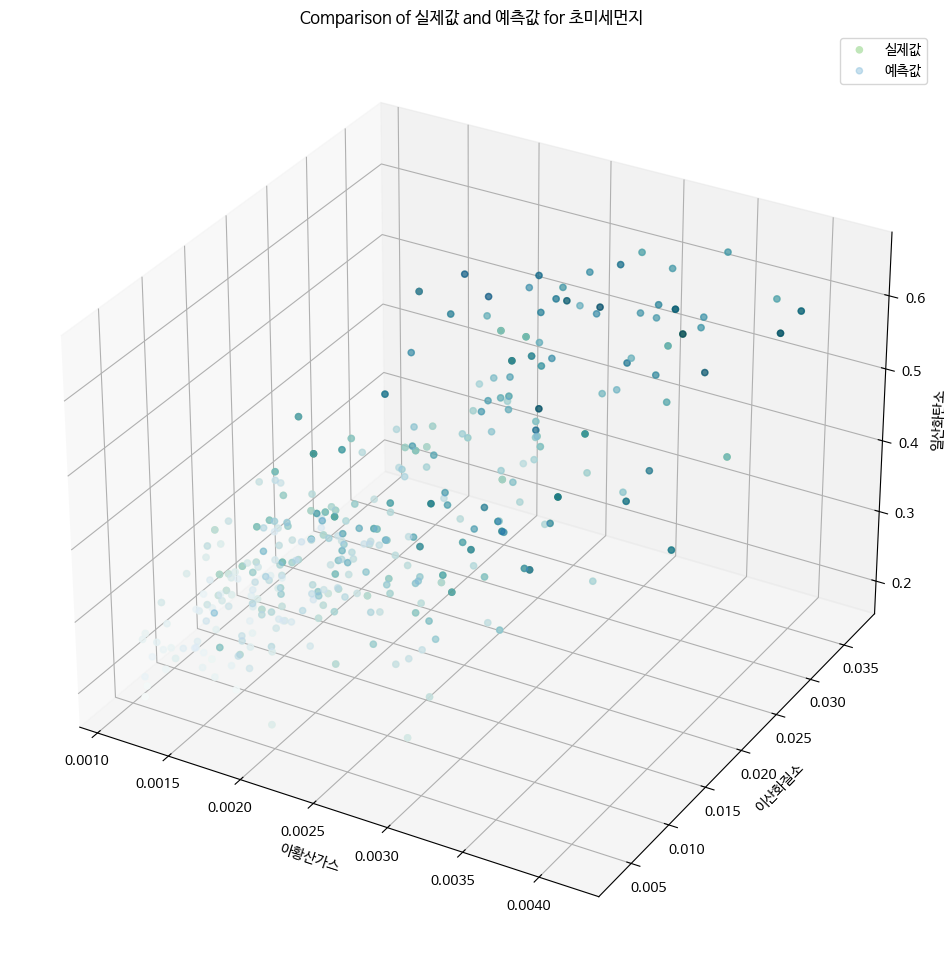

In [18]:
# 예측값과 실제값의 분포 시각화
# PM10과 PM2.5에 직접적인 영향이 미비한 O3(오존) 제외한 3차원 그래프
# PM10 시각화
y_true_pm10 = y_test['초미세먼지']
y_pred = pd.DataFrame(data=pred, columns=['초미세먼지', '미세먼지'])  # 컬럼에 이름붙여줌
#print(y_pred)
#print(pred)
y_pred_pm10 = y_pred['초미세먼지']

# 3차원 그래프 생성
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# X 변수 값들
x = X_test['아황산가스']
y = X_test['이산화질소']
z = X_test['일산화탄소']

# y_true와 y_pred의 값을 color로 설정하여 scatter plot 생성
ax.scatter(x, y, z, c=y_true_pm10, cmap='Greens', label='실제값')
ax.scatter(x, y, z, c=y_pred_pm10, cmap='Blues', alpha=0.5, label='예측값')

# 그래프 축과 제목 설정
ax.set_xlabel('아황산가스')
ax.set_ylabel('이산화질소')
ax.set_zlabel('일산화탄소')
plt.title('Comparison of 실제값 and 예측값 for 초미세먼지')
plt.legend()
plt.show()

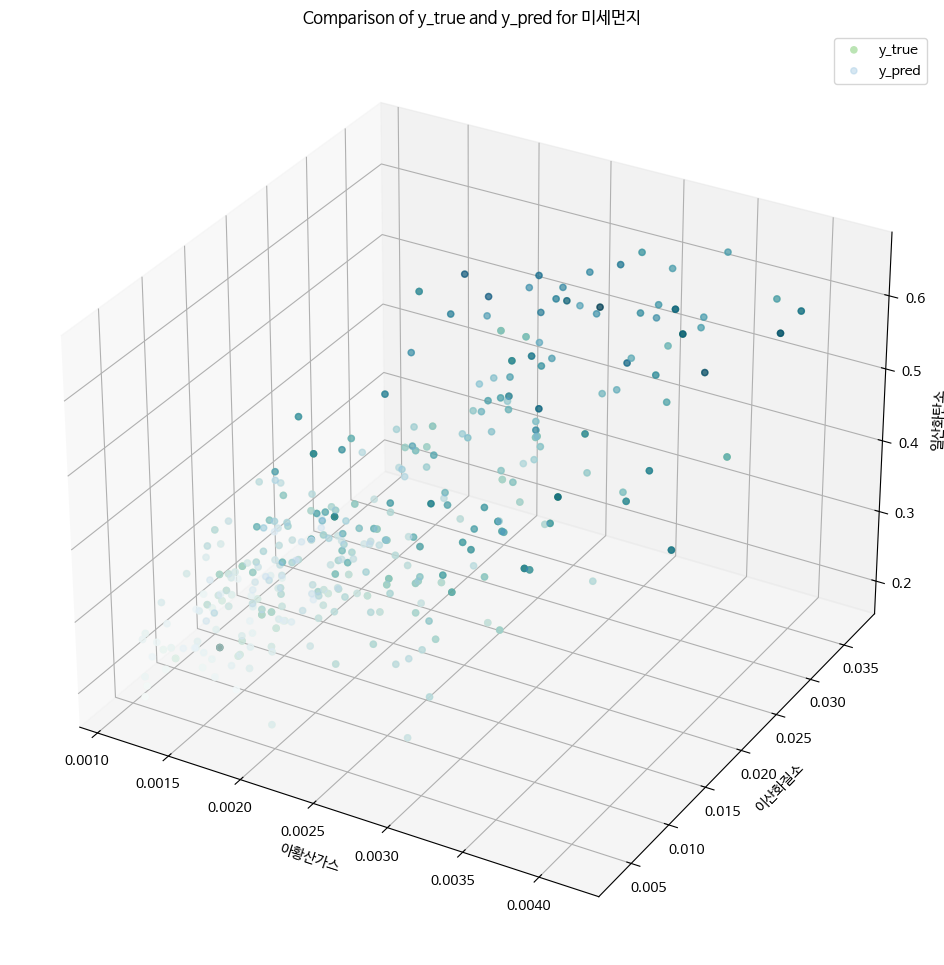

In [19]:
y_true_hpm = y_test['미세먼지']
y_pred_hpm = y_pred['미세먼지']

# 3차원 그래프 생성
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# X 변수 값들
x = X_test['아황산가스']
y = X_test['이산화질소']
z = X_test['일산화탄소']

# y_true와 y_pred의 값을 color로 설정하여 scatter plot 생성
ax.scatter(x, y, z, c=y_true_hpm, cmap='Greens', label='y_true')
ax.scatter(x, y, z, c=y_pred_hpm, cmap='Blues', alpha=0.5, label='y_pred')

# 그래프 축과 제목 설정
ax.set_xlabel('아황산가스')
ax.set_ylabel('이산화질소')
ax.set_zlabel('일산화탄소')
plt.title('Comparison of y_true and y_pred for 미세먼지')
plt.legend()
plt.show()

In [20]:
y_test

,미세먼지,초미세먼지
1610,26.317460,14.466970
385,30.116129,13.149837
1150,38.141994,16.957704
79,10.474227,6.299517
1027,22.295775,8.003509
...,...,...
395,63.288525,38.473856
1786,54.228643,34.842857
1709,9.073826,4.365854
122,42.142857,12.291262


In [21]:
# 모델 성능 평가
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 결정계수(R2 score)
print('R2 :',r2_score(y_test, pred))

# MSE
mse = mean_squared_error(y_test, pred)
print('MSE :', mse)

# RMSE
print('RMSE :',np.sqrt(mse))

# MAE
mae = mean_absolute_error(y_test, pred)
print('MAE :', mae)

R2 : 0.7202111734133098
MSE : 41.46641280841117
RMSE : 6.4394419640533425
MAE : 4.694392068323165


In [22]:
# 25.07.07 대구시의 데이터   '아황산가스', '이산화질소', '오존', '일산화탄소'   SO2       NO2        O3        CO
# 초미세먼지	PM-2.5	42㎍/㎥	보통
# 미세먼지	PM-10	32㎍/㎥	보통
# 오존	O₃	0.0515ppm	보통
# 이산화질소	NO₂	0.0227ppm	좋음
# 일산화탄소	CO	0.53ppm	좋음
# 아황산가스	SO₂	0.0027ppm	좋음
# 0.0027  0.0227  0.002478  0.981833
print(model.predict([[0.003627, 0.044765, 0.0515, 0.53]])) #42, 32
print(model.predict([[0.003, 0.044, 0.051, 0.5]]))

[[43.34576535 20.63785641]]
[[43.20889343 19.74106834]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
